In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import os
import numpy as np

np.float64(95.99553092424617)

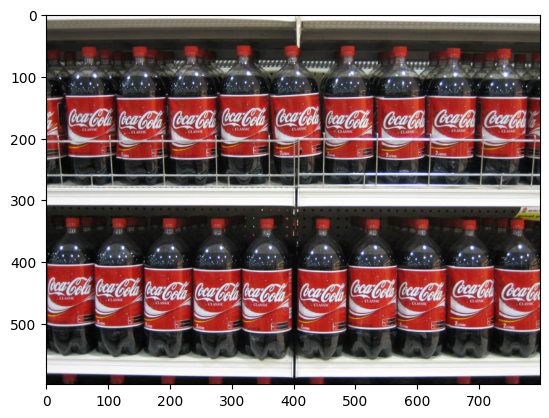

In [2]:
coca_multi = cv.cvtColor(cv.imread('images/coca_multi.png'), cv.COLOR_BGR2RGB)
plt.imshow(coca_multi)
np.mean(coca_multi)

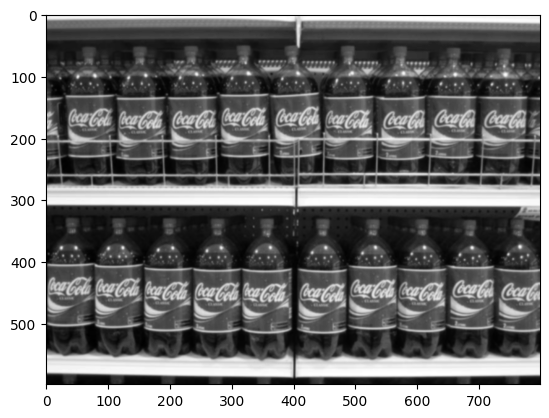

In [ ]:
def filter_closed_loops(gray):
    _, binary = cv.threshold(gray, 127, 255, cv.THRESH_BINARY)
    contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(binary)
    for contour in contours:
        if not cv.isContourConvex(contour):
            if cv.arcLength(contour, cv.isContourConvex(contour)) > 100 and cv.contourArea(contour) > 20:
                cv.drawContours(mask, [contour], -1, 255, thickness=cv.FILLED)
    filtered_image = cv.bitwise_and(binary, mask)
    return filtered_image
    
def preprocess(image, kernel_size=5, threshold_1=100, threshold_2=200):
    grayscale = cv.cvtColor(image, cv.COLOR_RGB2GRAY) if len(image.shape) == 3 else image.copy()
    blurred = cv.GaussianBlur(grayscale, (kernel_size, kernel_size), 0)
    canny_edges = cv.Canny(grayscale, threshold_1, threshold_2)
    canny_edges_after_blur = cv.Canny(blurred, threshold_1, threshold_2)
    kernel = np.ones((3, 3), np.uint8) 
    filtered = filter_closed_loops(canny_edges_after_blur)
    return grayscale, blurred, canny_edges, canny_edges_after_blur, filtered

def preprocess_(image, kernel_size=5, threshold_1=100, threshold_2=200):
    return preprocess(image, kernel_size, threshold_1, threshold_2)[4]

def preprocess_blur(image, kernel_size=5, threshold_1=100, threshold_2=200):
    return preprocess(image, kernel_size, threshold_1, threshold_2)[1]

grayscale, blurred, canny_edges, canny_edges_after_blur,filtered = preprocess(coca_multi, kernel_size=5)
plt.imshow(blurred, cmap='gray')

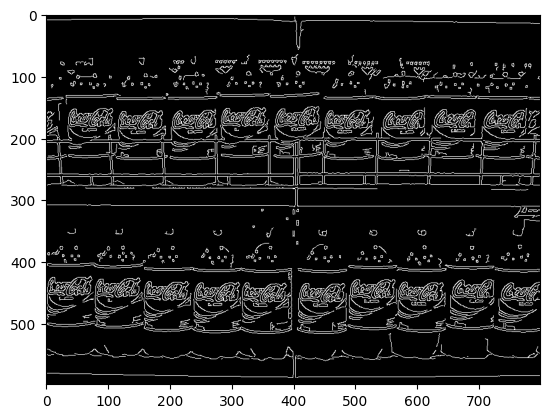

In [4]:
plt.imshow(canny_edges, cmap='gray')

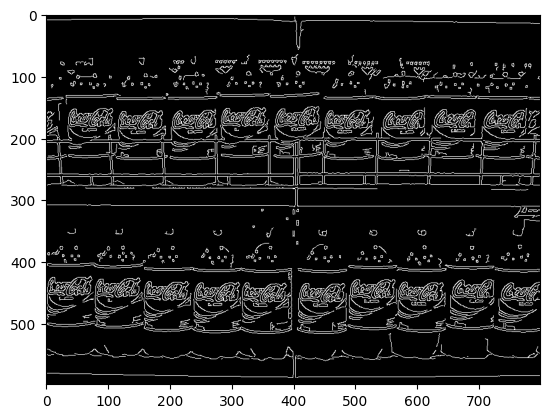

In [5]:
plt.imshow(canny_edges_after_blur, cmap='gray')

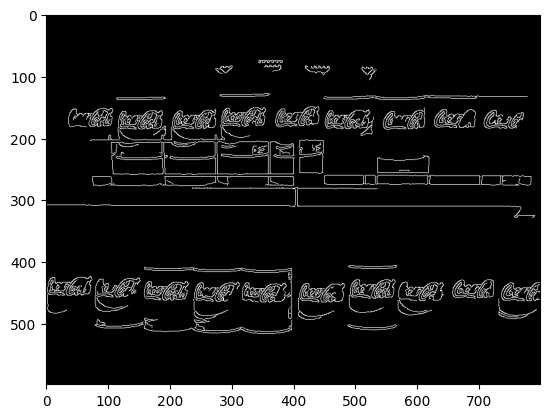

In [6]:
plt.imshow(filtered, cmap='gray')

2.9166666666666665

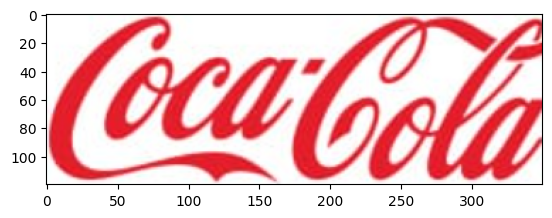

In [7]:
template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)
template_reduced = template[30:-25, 10:-40]
plt.imshow(template_reduced)
aspect_ratio = template_reduced.shape[1]/template_reduced.shape[0]
aspect_ratio

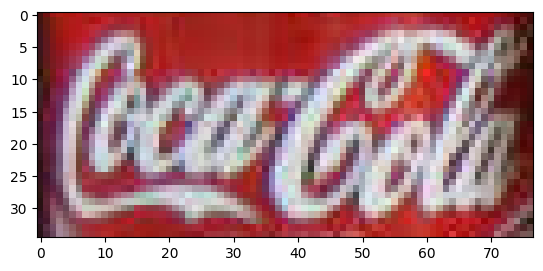

In [8]:
some_other = coca_multi.copy()
some_other = some_other[150:185,33:110,:]
plt.imshow(some_other)

In [9]:
some_other.shape

(35, 77, 3)

In [10]:
aspect_ratio = some_other.shape[1]/some_other.shape[0]
aspect_ratio

2.2

In [15]:
# esta es resizeando la img original
import imutils
import numpy as np

test_images = os.listdir('images')
test_images_paths = [f'images/{im}' for im in test_images]
test_images_color = [cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB) for path in test_images_paths]

def plot_images(img_list, img_names, method='', cols=3):
    rows = len(img_list)//cols + 1
    f, axes = plt.subplots(rows,cols, figsize=(20,15)) 
    axes = axes.flatten()
    
    for i,ax in enumerate(axes):
        if i < len(img_list):
            ax.imshow(img_list[i])
            ax.set_title(f'{img_names[i]} {method}')
        else:
            ax.axis('off')


def normalize(x, xmax, xmin):
    return (x - xmin) / (xmax - xmin)

def detect_logo(image_rgb, method, threshold=0.80):
    template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)
    template_reduced = template[30:-25, 10:-15]
    edged_template = preprocess_(template_reduced)
    
    modified_image = image_rgb.copy()
    gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
    tW, tH = edged_template.shape[::-1]
    found = {}    
    all_results = np.array([], dtype=np.float32)

    edged = preprocess_(image_rgb)
    # plt.imshow(edged, cmap='gray')
    
    for scale in np.linspace(0.2, 2.0, 40)[::-1]:
        # Resize the image according to the scale and keep track of the resizing ratio
        resized = imutils.resize(gray, width=int(gray.shape[1] * scale))
        r = gray.shape[1] / float(resized.shape[1])
        edged = preprocess_(resized)

        try:
            result = cv.matchTemplate(edged, edged_template, method)
            found[f'{resized.shape[0]},{resized.shape[1]},{r},{method}'] = result
            all_results = np.concatenate((all_results, result.flatten()))
        except Exception as e:
            # print('exception', e)
            pass
    print(all_results)
    min_result = np.min(all_results)
    max_result = np.max(all_results)
    
    bbox = []
    scores = []
    for scale_hash, result_scale in found.items():
        normalized_data = normalize(result_scale, max_result, min_result)
        loc = np.where(normalized_data >= threshold)
        r = float(scale_hash.split(',')[2])

        for pt in zip(*loc[::-1]):
            top_left = pt
            startX, startY = int(top_left[0]*r), int(top_left[1]*r)
            endX, endY = int((top_left[0]+tW)*r), int((top_left[1]+tH)*r)
            cv.rectangle(modified_image, (startX, startY), (endX, endY), (0, 0, 255), 2)
            bbox.append([startX, startY, endX, endY])
            scores.append(normalized_data[top_left[1], top_left[0]])

    return bbox, scores, normalize(all_results, max_result, min_result), modified_image

# bbox_multi, scores_multi, hist_data, modified_image = detect_logo(coca_multi, cv.TM_CCORR_NORMED, threshold=0.80)
# plot_images([detect_logo(img, cv.TM_CCOEFF)[3] for img in test_images_color], test_images_paths)

[3.5959396e-01 3.5959396e-01 3.5959396e-01 ... 1.0652116e+06 1.4553611e+06
 4.1496166e+05]
[1.3617778e-01 1.5106866e-01 1.5862298e-01 ... 1.0118703e+06 1.3682311e+06
 8.1424588e+05]
[429988.4   39838.9  234913.66 ...      0.       -0.        0.  ]
[-1069920.9  -933441.1  -885994.5 ...  2563193.2  2875574.8  1692384.4]
[8.8421392e-01 8.1646717e-01 7.7531284e-01 ... 1.2663370e+06 1.4219208e+06
 2.1598930e+06]
[-319417.25   -59317.       5707.875 ... -200371.16  -110498.695
 -280726.28 ]
[-175783.9  -181643.6  -187503.   ... -603307.3  -893980.06 -924553.3 ]


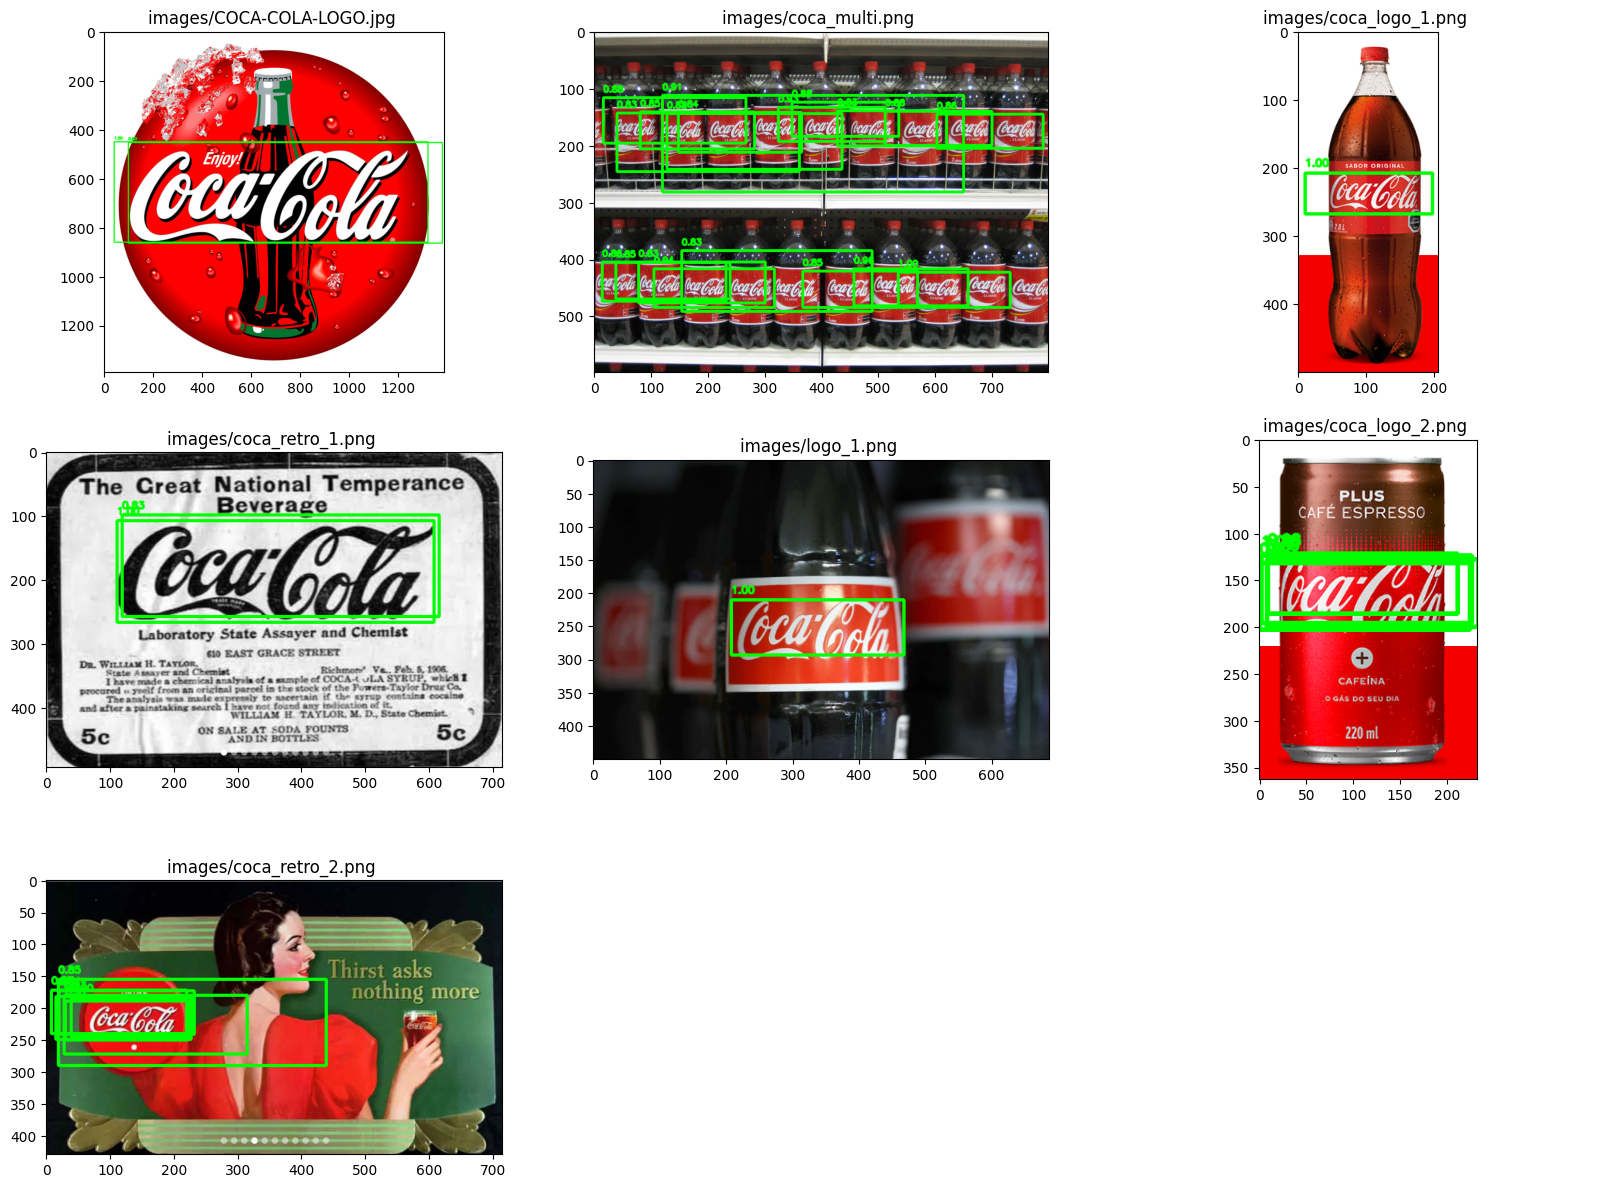

In [18]:
# def nms_suppresion(im):
nms_detections = []
for img in test_images_color:
    bbox, scores, normalized_results, modified_image = detect_logo(img, cv.TM_CCOEFF, threshold=0.8)

    result_img = img.copy()
    indices = cv.dnn.NMSBoxes(bboxes=bbox, scores=scores, score_threshold=0.82, nms_threshold=0.90, eta=0.99)
    # Filter out the boxes based on the NMS result
    filtered_boxes = [bbox[i] for i in indices.flatten()]
    filtered_scores = [scores[i] for i in indices.flatten()]
    # Draw the filtered boxes on the image
    for (xmin, ymin, xmax, ymax), score in zip(filtered_boxes, filtered_scores):
        cv.rectangle(result_img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
        text = f"{score:.2f}"
        cv.putText(
            result_img, 
            text, 
            (xmin, ymin - 10),  # Position text slightly above the top-left corner of the box
            cv.FONT_HERSHEY_SIMPLEX, 
            0.5,  # Font size
            (0, 255, 0),  # Font color (same as the box)
            2,  # Thickness
            cv.LINE_AA
        )
    nms_detections.append(result_img)
plot_images(nms_detections, test_images_paths)

Debido a limitaciones de tiempo, el equipo no pudo realizar un ajuste exhaustivo de los parámetros necesarios para que el algoritmo de Non-Maximum Suppression (NMS) funcione de manera óptima. Además, aunque una posible alternativa, habría sido el uso de la función groupRectangles.